In [ ]:
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from src.data.loaddata import load_data
import os
import matplotlib.pyplot as plt
import pickle
# 多个受试者的数据
USE_NANSEIZURE_DATA = False
SAVE_PROCESSED_DATA = True
USE_SAVED_DATA = True

o:\eeg\epilepsy_EEG_analysis_codepy
Loading data from data/data_subject_13.pkl for subject 13...
Loading data from data/data_subject_3.pkl for subject 3...
Loading data from data/data_subject_5.pkl for subject 5...
Loading data from data/data_subject_21.pkl for subject 21...
Loading data from data/data_subject_1.pkl for subject 1...
Loading data from data/data_subject_14.pkl for subject 14...
原始数据集样本数: 12
原始数据集正样本数: 122
原始数据集样本数: 17700
原始数据集正样本数: 338
训练集样本数: 3540
测试集样本数: 14160
训练集正样本数: 68
测试集正样本数: 270
过采样前的训练集样本数: 3540
过采样后的训练集样本数: 6944
训练集样本数: 5238
测试集样本数: 2246
332/332 [==============================] - 2s 5ms/step
Accuracy: 0.6389830508474577
F1 Score: 0.04436689930209372


<Figure size 640x480 with 0 Axes>

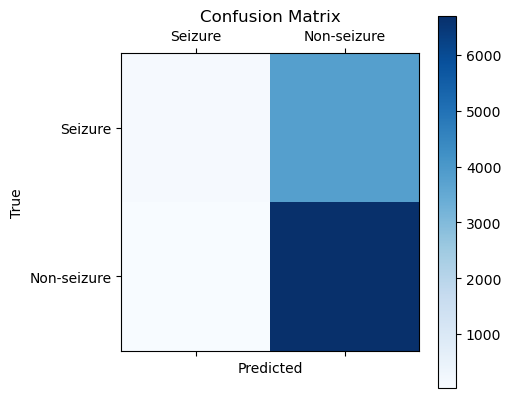

In [ ]:
# <读取含发作事件的数据> ----------------------------------------------------------
seizure_base_path = "data"
seizure_file_ids = [3, 5, 11, 13]
# 初始化 all_X 和 all_y 为空列表，用于存储所有主题的 X 和 y 数据
all_X_ws = []
all_y_ws = []

for file_id in seizure_file_ids:
    if USE_SAVED_DATA:
        data_file = f"{seizure_base_path}/data_subject_{file_id}.pkl"
        if os.path.exists(data_file):
            print(f"Loading data from {data_file} for subject {file_id}...")
            with open(data_file, 'rb') as f:
                X, y = pickle.load(f)
        else:
            print(f"Data file not found, loading and saving data for subject {file_id}...")
            X, y = load_data(file_id, seizure_base_path)

            if SAVE_PROCESSED_DATA:
                with open(data_file, 'wb') as f:
                    pickle.dump((X, y), f)
                print(f"Data saved to {data_file}.")
    else:
        X, y = load_data(file_id, seizure_base_path)
    all_X_ws.append(X)
    all_y_ws.append(y)
# <读取不含发作事件的数据> --------------------------------------------------------

val_subject_ids = [1, 14]  # Add more IDs as needed
val_base_path = "data"
val_all_X = []
val_all_y = []

for val_subject_id in val_subject_ids:
    val_data_file = f"{val_base_path}/data_subject_{val_subject_id}.pkl"
    if os.path.exists(val_data_file):
        print(f"Loading data from {val_data_file} for subject {val_subject_id}...")
        with open(val_data_file, 'rb') as f:
            val_X, val_y = pickle.load(f)
    else:
        print(f"Data file not found, loading and saving data for subject {val_subject_id}...")
        val_X, val_y = load_data(val_subject_id, val_base_path)

        # Save data
        with open(val_data_file, 'wb') as f:
            pickle.dump((val_X, val_y), f)
        print(f"Data saved to {val_data_file}.")

    val_all_X.append(val_X)
    val_all_y.append(val_y)



val_X = np.vstack(val_all_X)
val_y = np.concatenate(val_all_y)
print('原始数据集样本数:', len(val_X))
print('原始数据集正样本数:', np.sum(val_y))

# 合并 all_X 和 all_y
X = np.vstack(all_X)
X = X.reshape(-1, X.shape[-1])
val_X = np.vstack(val_all_X)
val_X = val_X.reshape(-1, val_X.shape[-1])
# 把 X 划分为两部分train_X和test_X（4:1）
# X_2d = X.reshape(X.shape[0], 2, -1)

from sklearn.model_selection import train_test_split

y = np.concatenate(all_y)
y = y.reshape(-1)
val_y = np.concatenate(val_all_y)
val_y = val_y.reshape(-1)
print('原始数据集样本数:', len(X))
print('原始数据集正样本数:', np.sum(y))

# 使用 train_test_split 进行随机分割，保持类别均衡
train_X, test_X, train_y, test_y = train_test_split(
    X, y, 
    test_size=0.8,  # 20% 作为测试集
    stratify=y,     # 保证类别均衡
    random_state=2024 # 固定随机种子以便复现
)

print('训练集样本数:', len(train_X))
print('测试集样本数:', len(test_X))
print('训练集正样本数:', np.sum(train_y))
print('测试集正样本数:', np.sum(test_y))

# 随机欠采样
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
#train_X_resampled, train_y_resampled = rus.fit_resample(train_X, train_y)
#test_X_resampled, test_y_resampled = rus.fit_resample(test_X, test_y)
val_X_resampled, val_y_resampled = rus.fit_resample(val_X, val_y)
# SMOTE 过采样
# 初始化 SMOTE 实例
smote = SMOTE()
# @NOTE: 训练集过采样还是有用的
print('过采样前的训练集样本数:', len(train_X))
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y)
print('过采样后的训练集样本数:', len(train_X_resampled))
# train_X_resampled, train_y_resampled = train_X, train_y
test_X_resampled, test_y_resampled = rus.fit_resample(test_X, test_y)
# 分割处理后的数据集
train_X_resampled = np.vstack((train_X_resampled, test_X_resampled))
train_y_resampled = np.concatenate((train_y_resampled, test_y_resampled))
train_2d = train_X_resampled.reshape(train_X_resampled.shape[0], 3, -1)
X_train, X_test, y_train, y_test = train_test_split(train_X_resampled, train_y_resampled, test_size=0.3, random_state=0)
print('训练集样本数:', len(X_train))
print('测试集样本数:', len(X_test))
# 训练决策树分类器
#clf = DecisionTreeClassifier(random_state=0)
#clf.fit(X_train, y_train)
# max-min normalization

# 训练随机森林分类器
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# @NOTE:-------------------------------------------------------------------------
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

X = train_2d
# max-min normalization
X = (X - np.min(X)) / (np.max(X) - np.min(X))
y = train_y_resampled

# 增加通道维度
X = X[:, :, :, np.newaxis]

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# 创建卷积神经网络模型
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(1, 3), activation='relu', input_shape=(3, 96, 1)))
model.add(Conv2D(filters=16, kernel_size=(1, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 输出层，使用 sigmoid 激活函数

# 编译模型
#model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
import keras
#model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(gamma=5.0, from_logits=False), metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 训练模型
model.fit(X, y, epochs=1, batch_size=32)

# 对 val_X 进行预测
val_X2d = val_X.reshape(val_X.shape[0], 3, -1, 1)
val_X2d = (val_X2d - np.min(val_X2d)) / (np.max(val_X2d) - np.min(val_X2d))  # 归一化
val_y_pred = model.predict(val_X2d)
val_y_pred = np.where(val_y_pred > 0.5, 1, 0)  # 二值化预测

# 计算准确率
accuracy = accuracy_score(val_y, val_y_pred)
print("Accuracy:", accuracy)

# 计算 F1 分数
f1 = f1_score(val_y, val_y_pred)
print("F1 Score:", f1)

# 计算混淆矩阵
tn, fp, fn, tp = confusion_matrix(val_y, val_y_pred).ravel()
plt.figure()
plt.matshow([[tp, fp], [fn, tn]], cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Seizure', 'Non-seizure'])
plt.yticks([0, 1], ['Seizure', 'Non-seizure'])
plt.title('Confusion Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

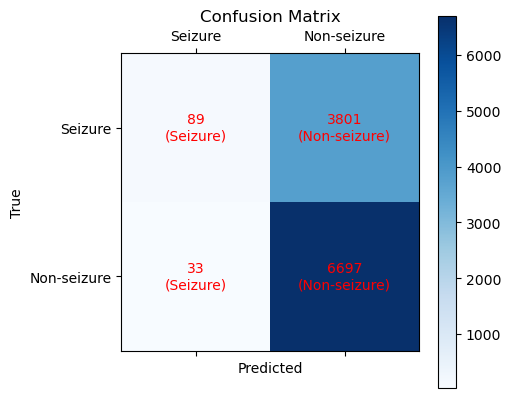

In [2]:
# 计算混淆矩阵+数量
tn, fp, fn, tp = confusion_matrix(val_y, val_y_pred).ravel()
plt.figure()
plt.matshow([[tp, fp], [fn, tn]], cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Seizure', 'Non-seizure'])
plt.yticks([0, 1], ['Seizure', 'Non-seizure'])
plt.title('Confusion Matrix')
plt.text(0, 0, f'{tp}\n(Seizure)', ha='center', va='center', color='red')
plt.text(1, 0, f'{fp}\n(Non-seizure)', ha='center', va='center', color='red')
plt.text(0, 1, f'{fn}\n(Seizure)', ha='center', va='center', color='red')
plt.text(1, 1, f'{tn}\n(Non-seizure)', ha='center', va='center', color='red')
plt.show()


In [3]:
# 评估指标
print('val 准确率:', accuracy_score(val_y, val_y_pred))
print('val F1 Score:', f1_score(val_y, val_y_pred))
print('val 召回率:', tp / (tp + fn))
print('val 特异性:', tn / (tn + fp))
print('val 精确率:', tp / (tp + fp))
print('val 负类预测准确率:', tn / (tn + fn))
print('val 正类预测准确率:', tp / (tp + fp))
print('val 正类预测准确率:', tp / (tp + fp))
print('val 负类预测准确率:', tn / (tn + fn))

val 准确率: 0.6389830508474577
val F1 Score: 0.04436689930209372
val 召回率: 0.7295081967213115
val 特异性: 0.6379310344827587
val 精确率: 0.02287917737789203
val 负类预测准确率: 0.9950965824665676
val 正类预测准确率: 0.02287917737789203
val 正类预测准确率: 0.02287917737789203
val 负类预测准确率: 0.9950965824665676


标签为1的数量: 122
预测为1的数量: 43
10491 7 86 36
val 准确率: 0.9912429378531074
val F1 Score: 0.43636363636363634
val 召回率: 0.29508196721311475
val 特异性: 0.9993332063250143
val 精确率: 0.8372093023255814
val 负类预测准确率: 0.9918691500425452
val 正类预测准确率: 0.8372093023255814
val 正类预测准确率: 0.8372093023255814
val 负类预测准确率: 0.9918691500425452


<Figure size 640x480 with 0 Axes>

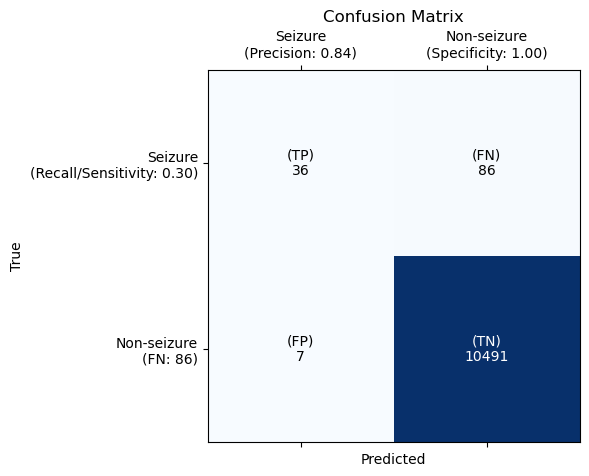

In [4]:
# 训练随机森林分类器
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
# 预测
# 输出y的正例数量
# 统计1的数量
count_ones = np.sum(val_y == 1)
print("标签为1的数量:", count_ones)
y_pred = clf.predict(val_X)
print("预测为1的数量:", np.sum(y_pred == 1))
# 评估指标
tn, fp, fn, tp = confusion_matrix(val_y, y_pred).ravel()
print(tn, fp, fn, tp)
print('val 准确率:', accuracy_score(val_y, y_pred))
print('val F1 Score:', f1_score(val_y, y_pred))
print('val 召回率:', tp / (tp + fn))
print('val 特异性:', tn / (tn + fp))
print('val 精确率:', tp / (tp + fp))
print('val 负类预测准确率:', tn / (tn + fn))
print('val 正类预测准确率:', tp / (tp + fp))
print('val 正类预测准确率:', tp / (tp + fp))
print('val 负类预测准确率:', tn / (tn + fn))

import matplotlib.pyplot as plt

# 计算 Precision, Recall, Sensitivity, Specificity
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
sensitivity = recall  # Sensitivity 和 Recall 是相同的
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

plt.figure()
plt.matshow([[tp, fn], [fp, tn]], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Seizure\n(Precision: {:.2f})'.format(precision), 'Non-seizure\n(Specificity: {:.2f})'.format(specificity)])
plt.yticks([0, 1], ['Seizure\n(Recall/Sensitivity: {:.2f})'.format(recall), 'Non-seizure\n(FN: {})'.format(fn)])
plt.title('Confusion Matrix')

# 添加标签和计数
plt.text(0, 0, f'(TP)\n{tp}', ha='center', va='center', color='black')  # True Positive
plt.text(1, 0, f'(FN)\n{fn}', ha='center', va='center', color='black')  # False Negative
plt.text(0, 1, f'(FP)\n{fp}', ha='center', va='center', color='black')  # False Positive
plt.text(1, 1, f'(TN)\n{tn}', ha='center', va='center', color='white')  # True Negative

plt.show()

